# Phân tích sự khác biệt giữa các nhóm bệnh nhân có và không có biến chứng

## Mục tiêu:
- So sánh đặc điểm chính của nhóm bệnh nhân có biến chứng và không có biến chứng  
- Xác định các yếu tố nguy cơ quan trọng (Tuổi, giới tính, huyết áp, cholesterol, nhịp tim tối đa)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 6)

df = pd.read_csv('../data/processed/processed_heart_disease.csv')

In [2]:
# Tạo biến phân nhóm
df['has_complication'] = (df['num'] > 0).astype(int)
df['complication_group'] = df['has_complication'].map({0: 'Không có biến chứng', 1: 'Có biến chứng'})

# Thống kê cơ bản
print("TỔNG QUAN DỮ LIỆU:")
print(f"Tổng số bệnh nhân: {len(df)}")
print(f"Tỷ lệ biến chứng: {df['has_complication'].mean()*100:.1f}%")
print("\nPhân bố nhóm:")
print(df['complication_group'].value_counts())

TỔNG QUAN DỮ LIỆU:
Tổng số bệnh nhân: 308
Tỷ lệ biến chứng: 46.4%

Phân bố nhóm:
complication_group
Không có biến chứng    165
Có biến chứng          143
Name: count, dtype: int64


### So sánh các yếu tố quan trọng

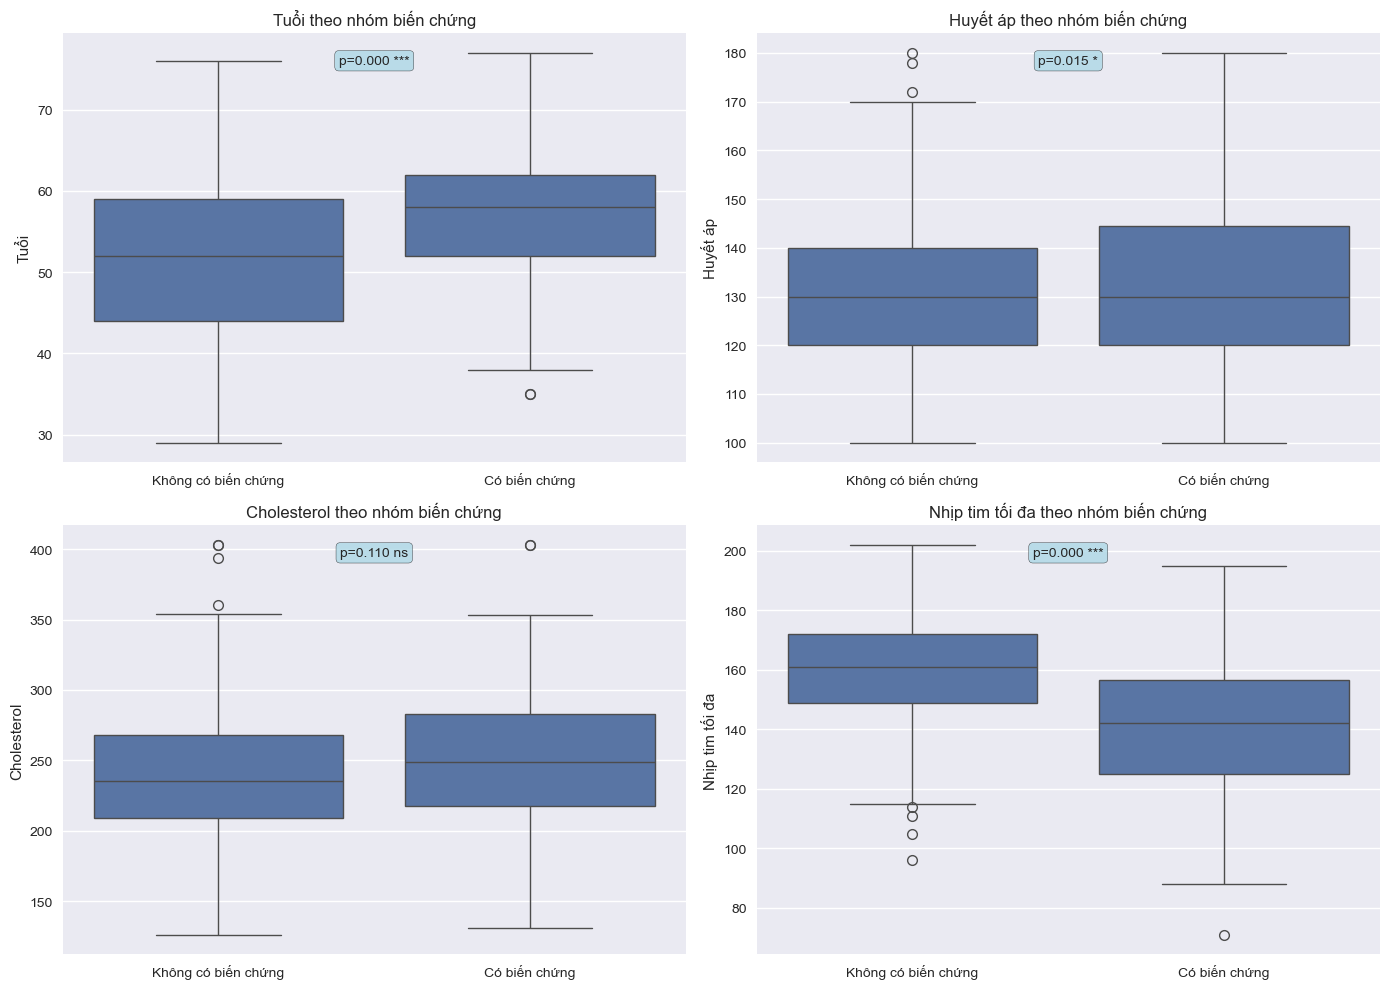


CÁC YẾU TỐ CÓ KHÁC BIỆT CÓ Ý NGHĨA:
- Tuổi: p=0.000, nhóm có biến chứng cao hơn 4.2
- Huyết áp: p=0.015, nhóm có biến chứng cao hơn 4.8
- Nhịp tim tối đa: p=0.000, nhóm có biến chứng thấp hơn 19.4


In [3]:
key_vars = ['age', 'trestbps', 'chol', 'thalach']
var_labels = ['Tuổi', 'Huyết áp', 'Cholesterol', 'Nhịp tim tối đa']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

significant_factors = []

for i, (var, label) in enumerate(zip(key_vars, var_labels)):
    # Box plot
    sns.boxplot(data=df, x='complication_group', y=var, ax=axes[i])
    axes[i].set_title(f'{label} theo nhóm biến chứng')
    axes[i].set_xlabel('')
    axes[i].set_ylabel(label)
    
    # Thống kê t-test
    no_comp = df[df['has_complication'] == 0][var]
    has_comp = df[df['has_complication'] == 1][var]
    stat, p_value = stats.ttest_ind(no_comp, has_comp)
    
    # Thêm kết quả thống kê
    significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
    axes[i].text(0.5, 0.95, f'p={p_value:.3f} {significance}', 
                transform=axes[i].transAxes, ha='center', va='top',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    # Lưu yếu tố có ý nghĩa
    if p_value < 0.05:
        mean_diff = has_comp.mean() - no_comp.mean()
        significant_factors.append({
            'factor': label,
            'p_value': p_value,
            'mean_diff': mean_diff,
            'effect': 'cao hơn' if mean_diff > 0 else 'thấp hơn'
        })

plt.tight_layout()
plt.show()

# In kết quả có ý nghĩa thống kê
print("\nCÁC YẾU TỐ CÓ KHÁC BIỆT CÓ Ý NGHĨA:")
for factor in significant_factors:
    print(f"- {factor['factor']}: p={factor['p_value']:.3f}, nhóm có biến chứng {factor['effect']} {abs(factor['mean_diff']):.1f}")

### Phân tích yếu tố giới tính và tuổi

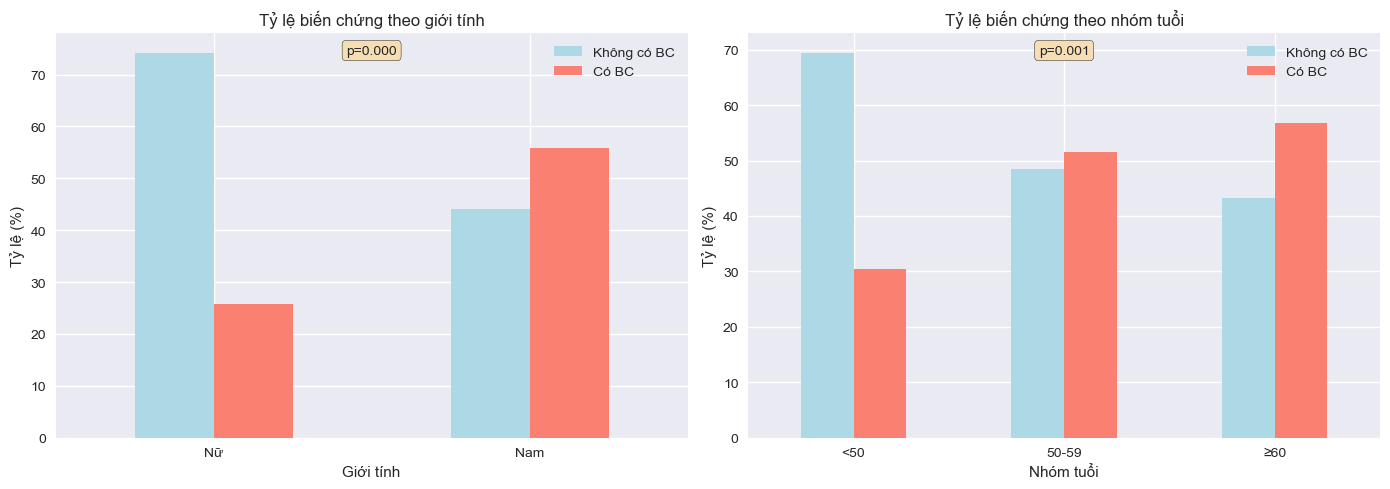

Giới tính và biến chứng: p=0.000
Tuổi và biến chứng: p=0.001


In [4]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Giới tính và biến chứng
gender_data = df.groupby(['sex', 'has_complication']).size().unstack(fill_value=0)
gender_data.index = ['Nữ', 'Nam']
gender_pct = gender_data.div(gender_data.sum(axis=1), axis=0) * 100

gender_pct.plot(kind='bar', ax=axes[0], color=['lightblue', 'salmon'])
axes[0].set_title('Tỷ lệ biến chứng theo giới tính')
axes[0].set_xlabel('Giới tính')
axes[0].set_ylabel('Tỷ lệ (%)')
axes[0].legend(['Không có BC', 'Có BC'])
axes[0].set_xticklabels(['Nữ', 'Nam'], rotation=0)

# Chi-square test cho giới tính
chi2, p_gender = stats.chi2_contingency(gender_data)[:2]
axes[0].text(0.5, 0.95, f'p={p_gender:.3f}', transform=axes[0].transAxes, 
             ha='center', bbox=dict(boxstyle='round', facecolor='wheat'))

# Tuổi và biến chứng  
df['age_group'] = pd.cut(df['age'], bins=[0, 50, 60, 100], labels=['<50', '50-59', '≥60'])
age_data = df.groupby(['age_group', 'has_complication']).size().unstack(fill_value=0)
age_pct = age_data.div(age_data.sum(axis=1), axis=0) * 100

age_pct.plot(kind='bar', ax=axes[1], color=['lightblue', 'salmon'])
axes[1].set_title('Tỷ lệ biến chứng theo nhóm tuổi')
axes[1].set_xlabel('Nhóm tuổi')
axes[1].set_ylabel('Tỷ lệ (%)')
axes[1].legend(['Không có BC', 'Có BC'])
axes[1].set_xticklabels(age_data.index, rotation=0)

# Chi-square test cho tuổi
chi2_age, p_age = stats.chi2_contingency(age_data)[:2]
axes[1].text(0.5, 0.95, f'p={p_age:.3f}', transform=axes[1].transAxes, 
             ha='center', bbox=dict(boxstyle='round', facecolor='wheat'))

plt.tight_layout()
plt.show()

print(f"Giới tính và biến chứng: p={p_gender:.3f}")
print(f"Tuổi và biến chứng: p={p_age:.3f}")

### Ma trận tương quan các yếu tố quan trọng

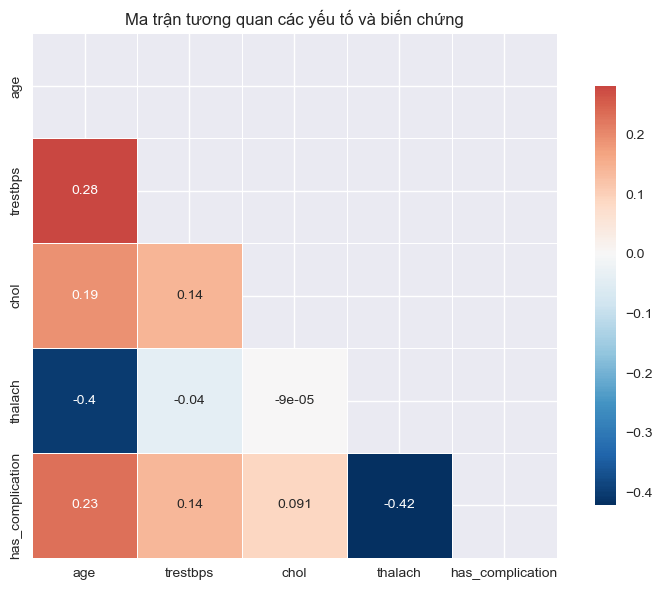

TƯƠNG QUAN VỚI BIẾN CHỨNG:
- Nhịp tim: 0.422
- Tuổi: 0.231
- Huyết áp: 0.139
- Cholesterol: 0.091


In [5]:
important_vars = ['age', 'trestbps', 'chol', 'thalach', 'has_complication']
corr_matrix = df[important_vars].corr()

plt.figure(figsize=(8, 6))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Ma trận tương quan các yếu tố và biến chứng')
plt.tight_layout()
plt.show()

# Tương quan mạnh với biến chứng
correlations = corr_matrix['has_complication'].abs().sort_values(ascending=False)[1:]
print("TƯƠNG QUAN VỚI BIẾN CHỨNG:")
for var, corr in correlations.items():
    var_name = {'age': 'Tuổi', 'trestbps': 'Huyết áp', 'chol': 'Cholesterol', 'thalach': 'Nhịp tim'}.get(var, var)
    print(f"- {var_name}: {corr:.3f}")

### KẾT LUẬN

In [6]:
# Thống kê tổng quan
total_patients = len(df)
complication_rate = df['has_complication'].mean() * 100

print(f"1. TỔNG QUAN:")
print(f"   - Tổng số bệnh nhân: {total_patients}")
print(f"   - Tỷ lệ biến chứng: {complication_rate:.1f}%")

# Các yếu tố có ý nghĩa thống kê
print(f"\n2. CÁC YẾU TỐ NGUY CƠ CHÍNH:")

# Kiểm tra các yếu tố
risk_factors = []

# Tuổi
age_corr = df['age'].corr(df['has_complication'])
risk_factors.append(('Tuổi', age_corr, 'tăng tuổi tăng nguy cơ' if age_corr > 0 else 'giảm tuổi tăng nguy cơ'))

# Giới tính
male_rate = df[df['sex'] == 1]['has_complication'].mean() * 100
female_rate = df[df['sex'] == 0]['has_complication'].mean() * 100
gender_diff = male_rate - female_rate
risk_factors.append(('Giới tính', abs(gender_diff)/100, f'Nam: {male_rate:.1f}%, Nữ: {female_rate:.1f}%'))

# Các yếu tố liên tục khác
for var, name in [('trestbps', 'Huyết áp'), ('chol', 'Cholesterol'), ('thalach', 'Nhịp tim tối đa')]:
    corr = df[var].corr(df['has_complication'])
    if abs(corr) > 0.1:  # Chỉ hiển thị tương quan đáng kể
        direction = 'tăng' if corr > 0 else 'giảm'
        risk_factors.append((name, abs(corr), f'{direction} {name.lower()} tăng nguy cơ'))

risk_factors.sort(key=lambda x: x[1], reverse=True)

for i, (factor, strength, description) in enumerate(risk_factors[:5], 1):
    print(f"   {i}. {factor}: {description}")

1. TỔNG QUAN:
   - Tổng số bệnh nhân: 308
   - Tỷ lệ biến chứng: 46.4%

2. CÁC YẾU TỐ NGUY CƠ CHÍNH:
   1. Nhịp tim tối đa: giảm nhịp tim tối đa tăng nguy cơ
   2. Giới tính: Nam: 55.9%, Nữ: 25.8%
   3. Tuổi: tăng tuổi tăng nguy cơ
   4. Huyết áp: tăng huyết áp tăng nguy cơ
